In [16]:
import numpy as np
import math as math
import matplotlib.pyplot as plt

In [17]:
x = np.linspace(1910, 2000, 10)
y = [92228496, 106021537, 123202624, 132164569,151325798, 179323175, 203211926, 226545805,248709873, 281421906]

# Таблица разделенных разностей

In [18]:
def difference_table(x,y):
    size = len(x)
    table = np.zeros([size, size])
    table[:,0] = y
    for j in range(1, size):
        for i in range(size - j):
            table[i][j] = (table[i+1][j-1] - table[i][j-1]) / (x[i+j]-x[i])
    return table[0, :]
print(difference_table(x,y))

[ 9.22284960e+07  1.37930410e+06  1.69402300e+04 -1.93453133e+03
  1.25106725e+02 -4.15059800e+00  8.05654167e-02 -7.56485278e-04
 -7.56467535e-06  5.09932804e-07]


# Интерполяционный полином в форме Ньютона

In [19]:
def newton_polynomial(x,y, data):
    coeffs = difference_table(x,y)
    size = len(data)
    values = []
    for xn in data:
        polynomial = coeffs[0]
        dx = 1
        for i in range(len(x)-1):
            dx *= xn - x[i]
            polynomial += dx*coeffs[i+1]
        values.append(polynomial)
    return values

In [20]:
val = newton_polynomial(x,y,[2010])[0]
print(val)
print("Ошибка = ", abs(val - 308745538))

827906509.0000029
Ошибка =  519160971.00000286


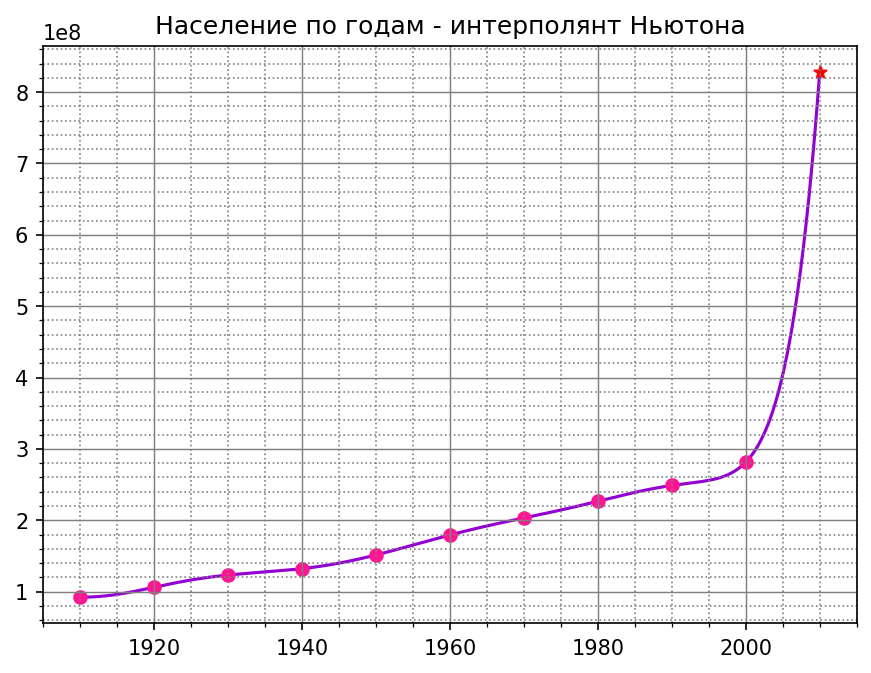

In [21]:
points = np.linspace(1910, 2010, 1000)
years = np.linspace(1910, 2010, 10)
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
plt.title("Население по годам - интерполянт Ньютона")
plt.scatter(2010,newton_polynomial(x,y,[2010]),color = 'red', marker="*")
plt.scatter(x,y,color = 'deeppink')
plt.plot(points,newton_polynomial(x,y,points),color = 'darkviolet',zorder = 0)
plt.minorticks_on()
plt.grid(which='major',
        color = 'grey', 
        linewidth = 0.7)
plt.grid(which='minor', 
        color = 'grey', 
        linestyle = ':')
plt.show()

# Кубический сплайн

In [22]:
def calculate_spline(i,a,b,c,d,dx):
    return a[i] + b[i]*dx + (c[i]/2)*dx**2 + (d[i]/6)*dx**3

In [23]:
def three_diag_solver(a, b, c, d):
    n = len(b)
    p, q = np.zeros(n), np.zeros(n)
    c = np.append(c,0)
    x = np.zeros(n+1)
    p[0] = - c[0] / b[0]
    q[0] = d[0] / b[0]
    for i in range(0, n):
        p[i] = - c[i] / (b[i] + (a[i] * p[i]))
        q[i] = (d[i] - (a[i] * q[i])) / (b[i] + (a[i] * p[i]))
    x[n] = d[-1]
    for i in range(n - 1, 0):
        x[i] = (d[i] - a[i] * q[i])/(a[i] * p[i]+b[i])
    return x

In [24]:
def calculate_c(y,h,n):
    a = np.zeros(n-1); b = np.zeros(n-1); c = np.zeros(n-1); d = np.zeros(n-1)
    d[0] = 0; d[n-2] = 0
    b[0] = 1; b[n-2] = 1
    for i in range(1, n - 1):
        b[i] = 2 * (h[i] + h[i+1])
        a[i-1] = h[i]
        c[i-1] = h[i+1]
    for i in range(1, n-2):
        d[i] = 6 * ((y[i+1] - y[i]) / h[i+1] - (y[i] - y[i-1]) / h[i])
    c[0] = 0
    a[n-2] = 0
    c_ = three_diag_solver(a, b, c, d)
    return c_

In [25]:
def spline(x,y,point):
    h = np.diff(x); h = np.append(h, h[-1])
    n = len(x)
    b = np.zeros(n); d = np.zeros(n)
    a = y

    c = calculate_c(y,h,n)
    for i in range(n-1, 0, -1):
        d[i] = (c[i] - c[i-1]) / h[i]
        b[i] = h[i] * (2.0 * c[i] + c[i-1]) / 6.0 + (y[i] - y[i - 1]) / h[i]

    d[0] = c[0] / h[0]
    b[0] = (y[1] - y[0]) / h[1] + (h[1] * c[0] / 3)

    for i in range(n):
        if point <= x[i]:
            dx = point - x[i]
            return calculate_spline(i,a,b,c,d,dx)
    return calculate_spline(n-1,a,b,c,d,point - x[n-1])

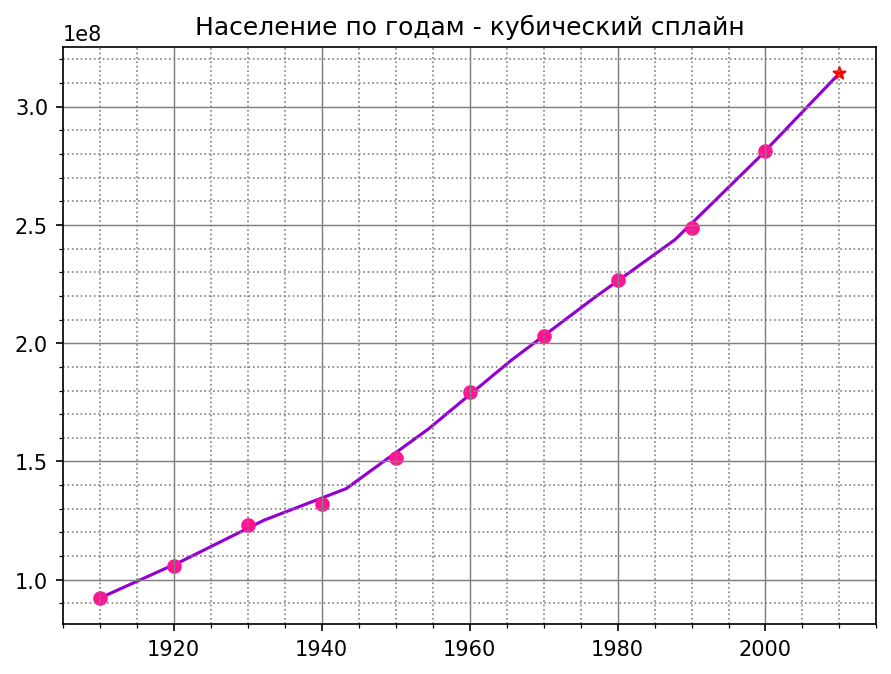

In [26]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
plt.title("Население по годам - кубический сплайн")
plt.plot(years,[spline(x,y,i) for i in years],color = 'darkviolet', zorder = 0)
plt.scatter(x,y,color = 'deeppink')
plt.scatter(2010,spline(x,y,2010),color = 'red', marker="*")
plt.minorticks_on()
plt.grid(which='major',
        color = 'grey', 
        linewidth = 0.7)
plt.grid(which='minor', 
        color = 'grey', 
        linestyle = ':')
plt.show()

In [27]:
val = spline(x,y,2010)
print(val)
print(308745538)
print("Ошибка = ", abs(val - 308745538))

314133939.0
308745538
Ошибка =  5388401.0
